# Uncertainty estimation in DNNs

Students: Gabriele Lorenzo, Paulo Roberto DE MOURA JÚNIOR

In a new python environment with python>=3.10 

In [50]:
#! pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev"

In [51]:
# here are the training parameters
batch_size = 32
learning_rate = 1e-3
weight_decay = 2e-4
lr_decay_epochs = 20
lr_decay = 0.1
nb_epochs = 50

In [52]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [53]:
import numpy as np
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from torch_uncertainty.datasets import MUAD
from torch import optim
from torch.optim import lr_scheduler
from torch_uncertainty.metrics.classification import MeanIntersectionOverUnion

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="train",
    transforms=train_transform,
    download=True,
)
val_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="val",
    transforms=val_transform,
    download=True,
)
test_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="test",
    transforms=val_transform,
    download=True,
)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [54]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

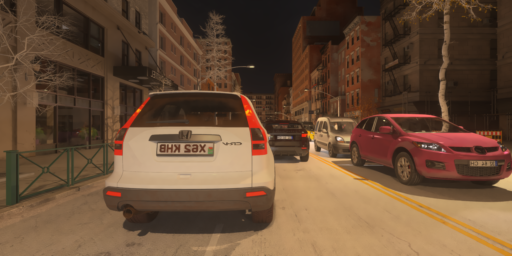

In [55]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

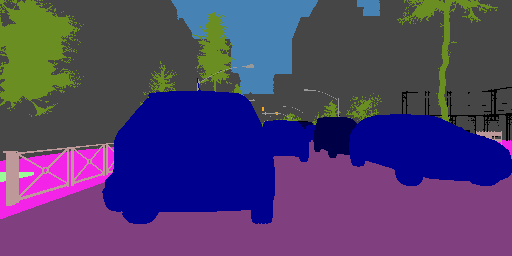

In [56]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(
    img, tgt_masks, alpha=1, colors=val_set.color_palette
)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [57]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

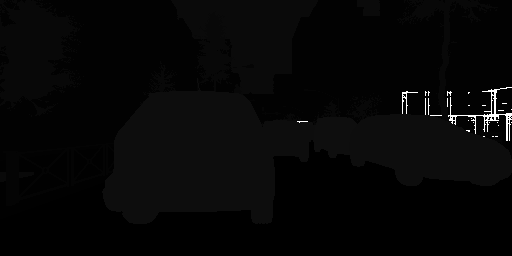

In [58]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [59]:
im.size

(512, 256)

**Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**  

The target image is dark because each pixel should belong to a class which are numbered from 0 to 20, and this range of values corresponds to darker intensities in 8-bit grayscale images. The bright part corresponds to the value 255 which is the maximum value for 8-bit grayscale images and it represents non-labeled pixels.

In [60]:
im_numpy = np.array(im)
np.set_printoptions(threshold=np.inf)
print(im_numpy[100:200, 400:])

[[  2   2 255 255   2   2 255   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2   2   2   2 255   2   2 255   2   2   2   2   2   2   2
    2   2   2   8   8   8   8   8   8   2   2 255   2   2 255   2   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2 255 255   2 255 255   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2]
 [  2   2 255 255   2   2 255   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2   2   2   2 255   2   2 255   2   2   2   2   2   2   2
    2   2   8   8   8   8   8   8   8   8   8 255   2   2 255   2   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2 255   2   2 255 255   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2]
 [  2   2 255   2   2   2 255   2   2   2   2   2   2   2   2   2   2   2


**Q3/ please study the dataset a bit. What it is about?**  

The MUAD dataset for semantic segmentation corresponds to images generated by simulation as if there was a camera in a car driving through a city. As annotations we have the ground-truth segmentation maps for each image for 21 classes. The size of the dataset is shown below and we can see that it's highly class-unbalanced, which means some classes naturally have less pixels across the annotations.


In [61]:
# dataset statistics
from collections import Counter
from matplotlib import pyplot as plt

len_training_set = len(train_set)
len_validation_set = len(val_set)
len_test_set = len(test_set)
total = len_training_set + len_validation_set + len_test_set
print(f"Samples in Training set: {len_training_set} ({len_training_set / total:.1%})")
print(
    f"Samples in Validation set: {len_validation_set} ({len_validation_set / total:.1%})"
)
print(f"Samples in Test set: {len_test_set} ({len_test_set / total:.1%})")

train_dist = Counter()
val_dist = Counter()
test_dist = Counter()

train_pixel_count = 0
for _, tgt in train_set:
    train_dist.update(tgt.flatten().tolist())
    train_pixel_count += tgt.numel()

val_pixel_count = 0
for _, tgt in val_set:
    val_dist.update(tgt.flatten().tolist())
    val_pixel_count += tgt.numel()

test_pixel_count = 0
for _, tgt in test_set:
    test_dist.update(tgt.flatten().tolist())
    test_pixel_count += tgt.numel()

train_dist = {k: v / train_pixel_count for k, v in train_dist.items()}
val_dist = {k: v / val_pixel_count for k, v in val_dist.items()}
test_dist = {k: v / test_pixel_count for k, v in test_dist.items()}

Samples in Training set: 400 (70.7%)
Samples in Validation set: 54 (9.5%)
Samples in Test set: 112 (19.8%)


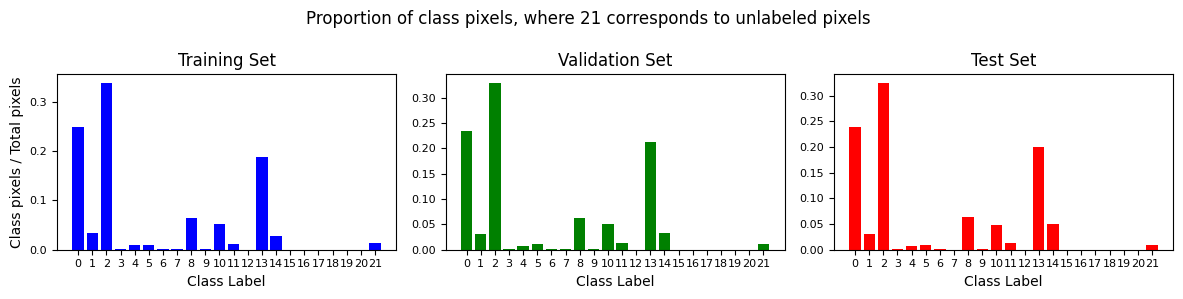

In [62]:
train_dist = {21 if k == 255 else k: v for k, v in train_dist.items()}
val_dist = {21 if k == 255 else k: v for k, v in val_dist.items()}
test_dist = {21 if k == 255 else k: v for k, v in test_dist.items()}

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle("Proportion of class pixels, where 21 corresponds to unlabeled pixels")

# Training set distribution
axs[0].bar(train_dist.keys(), train_dist.values(), color="blue")
axs[0].set_title("Training Set")
axs[0].set_xlabel("Class Label")
axs[0].set_ylabel("Class pixels / Total pixels")
axs[0].set_xticks(range(22))

# Validation set distribution
axs[1].bar(val_dist.keys(), val_dist.values(), color="green")
axs[1].set_title("Validation Set")
axs[1].set_xlabel("Class Label")
axs[1].set_xticks(range(22))

# Test set distribution
axs[2].bar(test_dist.keys(), test_dist.values(), color="red")
axs[2].set_title("Test Set")
axs[2].set_xlabel("Class Label")
axs[2].set_xticks(range(22))

axs[0].tick_params(axis="both", labelsize=8)
axs[1].tick_params(axis="both", labelsize=8)
axs[2].tick_params(axis="both", labelsize=8)
plt.tight_layout()
plt.show()

In [63]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import os

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()
)

In [64]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): An additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0

    for _, label in dataloader:
        label = label.cpu().numpy()
        # Flatten label
        flat_label = label.flatten()
        flat_label = flat_label[flat_label != 255]

        # Sum up the number of pixels of each class and the total pixel
        # counts for each label
        class_count += np.bincount(flat_label, minlength=num_classes)
        total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [65]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().to(device)
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444, 50.4983,  5.2256, 21.1894, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


**Q4/ why do we need to evaluate the class_weights?**

As seen above the dataset is highly class-unbalanced, so when using cross-entropy as loss function the most numerous classes will have more weight in the loss calculation. This can lead to the model being biased towards the most numerous classes and not learning well the less numerous ones. By evaluating the class weights we can balance the loss function and make the model learn all classes equally.

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**  

The architecture used here is slightly different from UNet, since:
1) We use batch normalization after each convolutional layer which is not present in the original UNet
2) We use dropout in the decoder part which is not present in the original UNet
3) We consider bilinear interpolation as an option for upsampling in the decoder part, which is not present in the original UNet

**Q6/Do we need a backbone with Unet?**  

Althought using a pre-trained model for the encoder part could save us time and computational ressources, we can still train an end-to-end model without a backbone, which is what we do here.

In [66]:
from torch import nn


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(
                x1,
                size=[2 * x1.size()[2], 2 * x1.size()[3]],
                interpolation=v2.InterpolationMode.BILINEAR,
            )
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2]
        )

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)


# please note that we have added dropout layer to be abble to use MC dropout
class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [67]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]


def plot_losses(train_history, val_history):
    x = 5 * np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()


def plot_accu(train_history, val_history):
    x = 5 * np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?**

IoU (Intersection over Union) is a widely used evaluation metric in computer vision, especially for tasks like object detection, semantic segmentation, and instance segmentation. It measures the overlap between two regions: a predicted region (output from a model) and the ground truth (actual label).

### Training function

**Q8/Please complete the training and the test function**

In [68]:
from torchmetrics.utilities.compute import _safe_divide


def train(model, data_loader, optim, criterion, metric, iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()

    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].to(device)  # [B, 3, H, W]
        labels = batch_data[1].squeeze(1).to(device)  # [B, 1, H, W]

        # Forward propagation
        logits = model(img)

        # Flatten logits and labels
        flatten_logits = rearrange(logits, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255

        # Loss computation
        loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])
        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(
            flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach()
        )

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute().item()

### Validation function

In [69]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()

    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].to(device)
        labels = batch_data[1].squeeze(1).to(device)

        with torch.no_grad():
            # Forward propagation
            logits = model(img)

            # Flatten logits and labels
            flatten_logits = rearrange(logits, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255

            # Loss computation
            loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute().item()

## E. Training Process

**Q9/ please train your DNN and comment?**

The training process is shown below. We can see that the model is learning, since the loss is decreasing and the meanIoU is increasing, for some classes the IoU is very low or NaN, which means the model is not learning well these classes, even that we're using the class weights to balance the loss.

In [70]:
print("\nTraining...\n")
num_classes = 19

# Intialize UNet
model = UNet(num_classes).to(device)
model = torch.nn.DataParallel(model)

# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion combines LogSoftMax and NLLLoss.
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay)
metric = MeanIntersectionOverUnion(num_classes=num_classes).to(device)


Training...



In [ ]:
# Start Training
train_loss_history = []
val_loss_history = []
train_miou_history = []
val_miou_history = []

best_val_miou = -1
model_save_path = "model.pth"

for epoch in range(nb_epochs):
    print(f">>>> [Epoch: {epoch}] Training")

    # Train the model
    train_loss, train_iou_per_class, train_miou = train(
        model, train_loader, optimizer, criterion, metric
    )

    print(
        f">>>> [Epoch: {epoch}] Avg. loss: {train_loss:.4f} | Mean IoU: {train_miou:.4f}"
    )

    if (epoch + 1) % 5 == 0:
        train_loss_history.append(train_loss)
        train_miou_history.append(train_miou)

        val_loss, val_iou_per_class, val_miou = test(
            model, val_loader, criterion, metric
        )
        val_loss_history.append(val_loss)
        val_miou_history.append(val_miou)

        print(f">>>> [Epoch: {epoch}] Validation")
        print(
            f">>>> [Epoch: {epoch}] Avg. loss: {val_loss:.4f} | Mean IoU: {val_miou:.4f}"
        )

        for cls_name, cls_iou in zip(val_set.classes, val_iou_per_class):
            print(f"{cls_name.name}: {cls_iou:.4f}")

        # Check if this is the best model so far
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            print("\nBest model so far. Saving...")
            torch.save(model.state_dict(), model_save_path)
            print(f"\nModel saved to {model_save_path}")

    # Update the learning rate
    scheduler.step()

# save loss and miou history
np.save("logs/train_loss_history.npy", np.array(train_loss_history))
np.save("logs/val_loss_history.npy", np.array(val_loss_history))
np.save("logs/train_miou_history.npy", np.array(train_miou_history))
np.save("logs/val_miou_history.npy", np.array(val_miou_history))

Load a model

In [72]:
# Loading a model
model = UNet(19).to(device)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("model1.pth"))

train_loss_history = np.load("logs/train_loss_history.npy")
val_loss_history = np.load("logs/val_loss_history.npy")
train_miou_history = np.load("logs/train_miou_history.npy")
val_miou_history = np.load("logs/val_miou_history.npy")

/tmp/ipykernel_1181792/1734607600.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model1.pth"))


# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**  

Both the training and test loss curves show a similar downward trend, stabilizing between 0.6 and 0.4. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.75, whereas the test mIoU plateaus at around 0.65. This discrepancy indicates a possible overfitting to the training dataset.

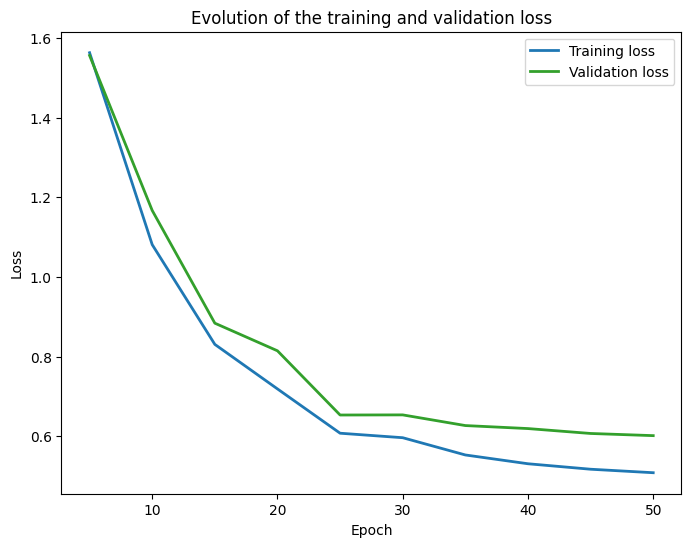

In [73]:
plot_losses(train_loss_history, val_loss_history)

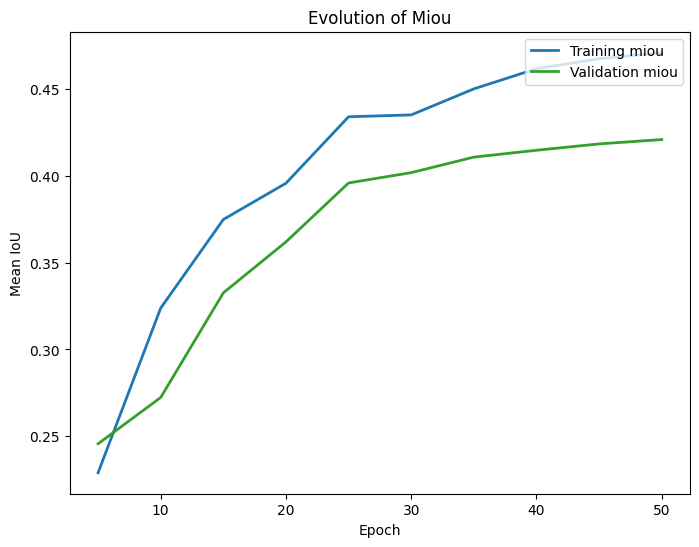

In [74]:
plot_accu(train_miou_history, val_miou_history)

**Q11/ what should we have done to avoid overfitting?**

To avoid overfitting we could have used data augmentation techniques, such as random rotations, flips, and scaling, to artificially increase the size and thus the variability of the training dataset. We could also have applied early stopping to stop the training process when the validation loss stops decreasing.

In [75]:
# Now we evaluate the model on all the test set.
torch.cuda.empty_cache()

loss, iou, miou = test(model, test_loader, criterion, metric, iteration_loss=True)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss, " | Mean IoU: ", miou)
# Print per class IoU on last epoch or if best iou
for key, class_iou in zip(test_set.classes[:19], iou, strict=True):
    print(f"{key}: {class_iou:.4f}")

[Step: 0] Iteration loss: 0.5718
[Step: 1] Iteration loss: 0.6575
[Step: 2] Iteration loss: 0.5672
[Step: 3] Iteration loss: 0.5816
>>>> [FINAL TEST on the test set: ] Avg. loss:  0.5944974273443222  | Mean IoU:  0.4345325827598572
MUADClass(name='road', id=0, color=(128, 64, 128)): 0.9356
MUADClass(name='sidewalk', id=1, color=(244, 35, 232)): 0.7117
MUADClass(name='building', id=2, color=(70, 70, 70)): 0.8026
MUADClass(name='wall', id=3, color=(102, 102, 156)): 0.0000
MUADClass(name='fence', id=4, color=(190, 153, 153)): 0.4194
MUADClass(name='pole', id=5, color=(153, 153, 153)): 0.2135
MUADClass(name='traffic_light', id=6, color=(250, 170, 30)): 0.0000
MUADClass(name='traffic_sign', id=7, color=(220, 220, 0)): 0.0000
MUADClass(name='vegetation', id=8, color=(107, 142, 35)): 0.5833
MUADClass(name='terrain', id=9, color=(152, 251, 152)): 0.0000
MUADClass(name='sky', id=10, color=(70, 130, 180)): 0.9191
MUADClass(name='person', id=11, color=(220, 20, 60)): 0.3709
MUADClass(name='rider'

## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [76]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
model.eval()

with torch.no_grad():
    # Forward propagation
    outputs = model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    confidence, pred = outputs_proba.max(0)

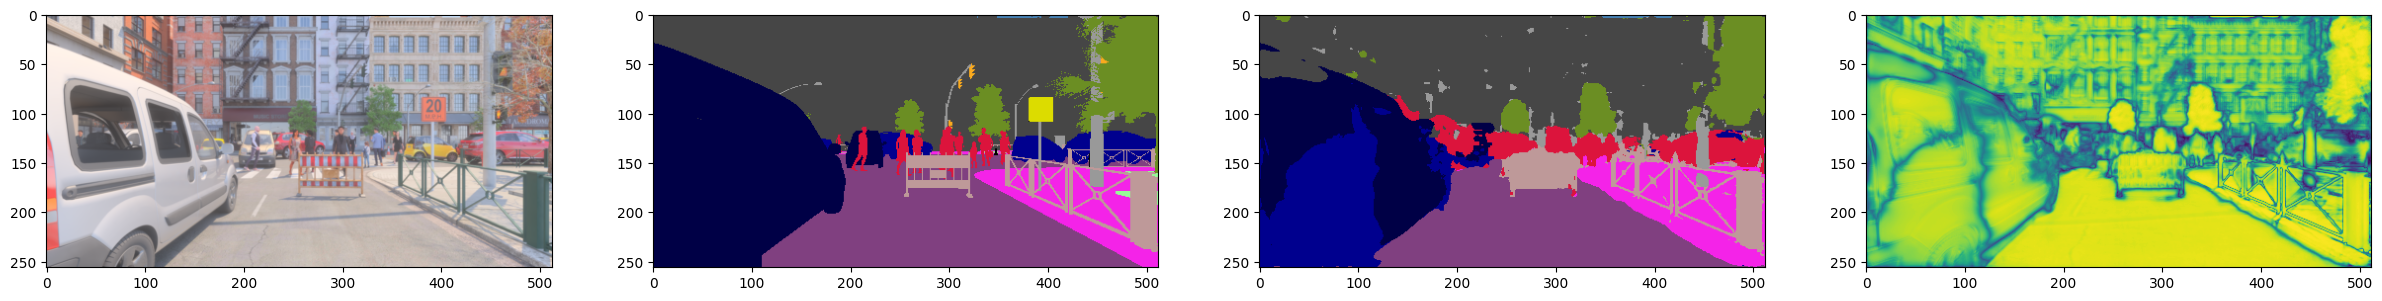

In [77]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(
    img, target_masks, alpha=1, colors=test_set.color_palette
)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(
    img, pred_masks, alpha=1, colors=test_set.color_palette
)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**  

The last image represents the maximum class probability (MCP) for each pixel prediction and it's computed as the maximum value of the softmax output which is a probability distribution over the classes, so if the MCP is high the model is more confident about its prediction since the other class probabilites will be low. The bright areas represent high confidence predictions (high MCP) and the dark areas represent low confidence predictions (low MCP), but it doesn't mean the predictions are correct.

### Now let's load the OOD test set

In [78]:
test_ood_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="ood",
    transforms=val_transform,
    download=True,
)
test_ood_set

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [79]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
model.eval()

with torch.no_grad():
    # Forward propagation
    outputs = model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    confidence, pred = outputs_proba.max(0)

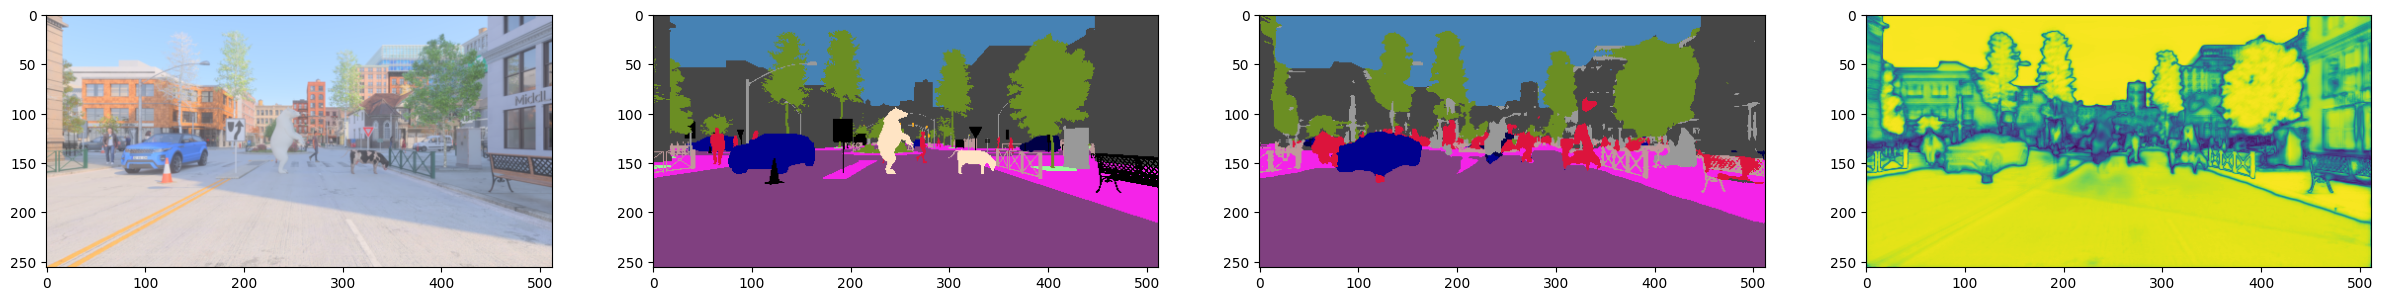

In [80]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(
    img, target_masks, alpha=1, colors=test_set.color_palette
)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(
    img, pred_masks, alpha=1, colors=test_set.color_palette
)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**  

The model is not very confident about the bear but it's confident about the goat, since some parts of the goat body are marked as high MCP and almost all the bear body is marked as low MCP. The model is not confident about the bench since the MCP is low for most of the bench pixels.


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**  

The first question was already answered above. We can see that the model is confident to predict some parts of the image where the segmentation is wrong, such as the the goat that should have a low MCP since it was not seen during training and some parts of the road.

## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

(<Figure size 900x1260 with 2 Axes>,
 array([<Axes: title={'center': 'Reliability Diagram'}, xlabel='Top-class Confidence (%)', ylabel='Success Rate (%)'>,
        <Axes: xlabel='Top-class Confidence (%)', ylabel='Density (%)'>],
       dtype=object))

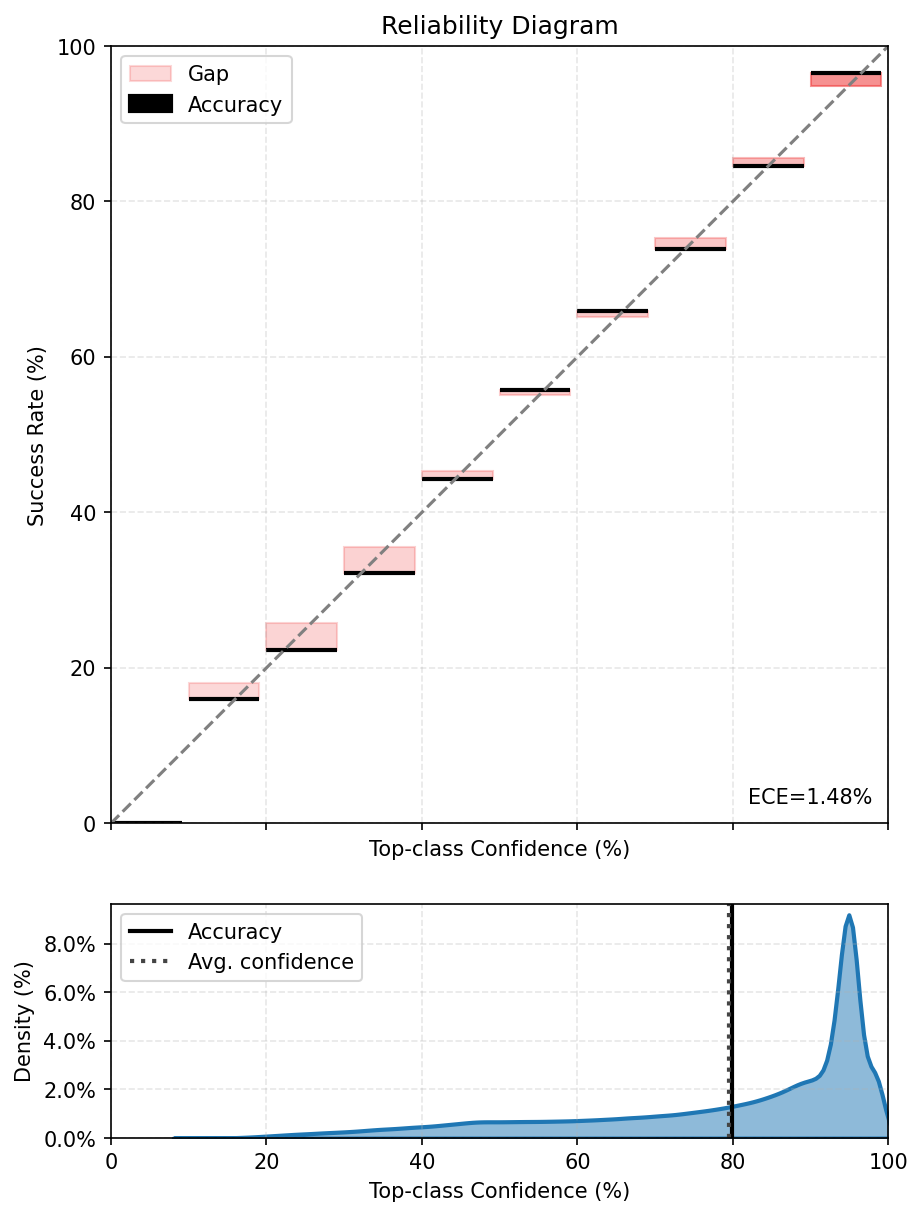

In [81]:
from torch_uncertainty.metrics import CalibrationError

calibration_error = CalibrationError(task="multiclass", num_classes=19).to(device)

for img, target in test_ood_set:
    batch_img = img.unsqueeze(0).to(device)
    batch_target = target.to(device)

    with torch.no_grad():
        # Forward propagation
        outputs = model(batch_img)
        outputs_proba = outputs.softmax(dim=1)

    calibration_error.update(outputs_proba.to(device), batch_target.to(device))

calibration_error.plot()

**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**  

The model appears to be overconfident because the top-class confidence is generally higher than the actual accuracy. This is evident in the first plot, where the accuracy falls below the confidence values instead of aligning along the diagonal. Similarly, in the second plot, the peak confidence should be closer to the accuracy line, but it is noticeably higher.

After temperature scaling

In [82]:
from torch_uncertainty.post_processing import TemperatureScaler


class CalibrationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        target = target.masked_fill(target > 18, -100)
        return img, target.squeeze(0)


cal_set = CalibrationDataset(val_set)

scaled_model = TemperatureScaler(model=model, device=device)
scaled_model.fit(cal_set)

100%|██████████| 2/2 [00:12<00:00,  6.39s/it]


(<Figure size 900x1260 with 2 Axes>,
 array([<Axes: title={'center': 'Reliability Diagram'}, xlabel='Top-class Confidence (%)', ylabel='Success Rate (%)'>,
        <Axes: xlabel='Top-class Confidence (%)', ylabel='Density (%)'>],
       dtype=object))

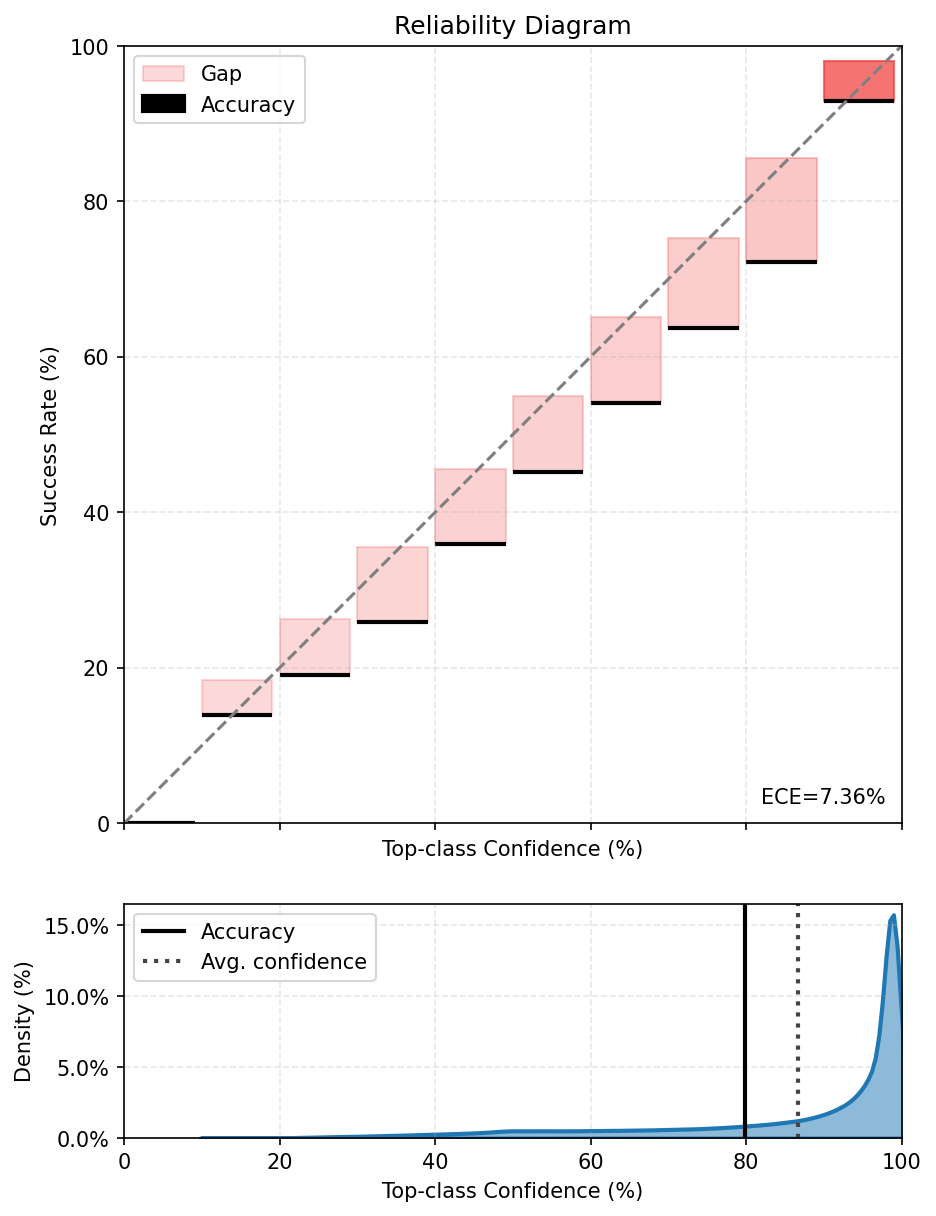

In [83]:
calibration_error = CalibrationError(task="multiclass", num_classes=19).to(device)

for img, target in test_ood_set:
    batch_img = img.unsqueeze(0).to(device)
    batch_target = target.to(device)

    with torch.no_grad():
        # Forward propagation
        outputs = scaled_model(batch_img)
        outputs_proba = outputs.softmax(dim=1)

    calibration_error.update(outputs_proba.to(device), batch_target.to(device))

calibration_error.plot()

Now let's see the new confidence score image after scaling

In [84]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)
scaled_model.eval()

with torch.no_grad():
    # Forward propagation
    outputs = scaled_model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    confidence, pred = outputs_proba.max(0)

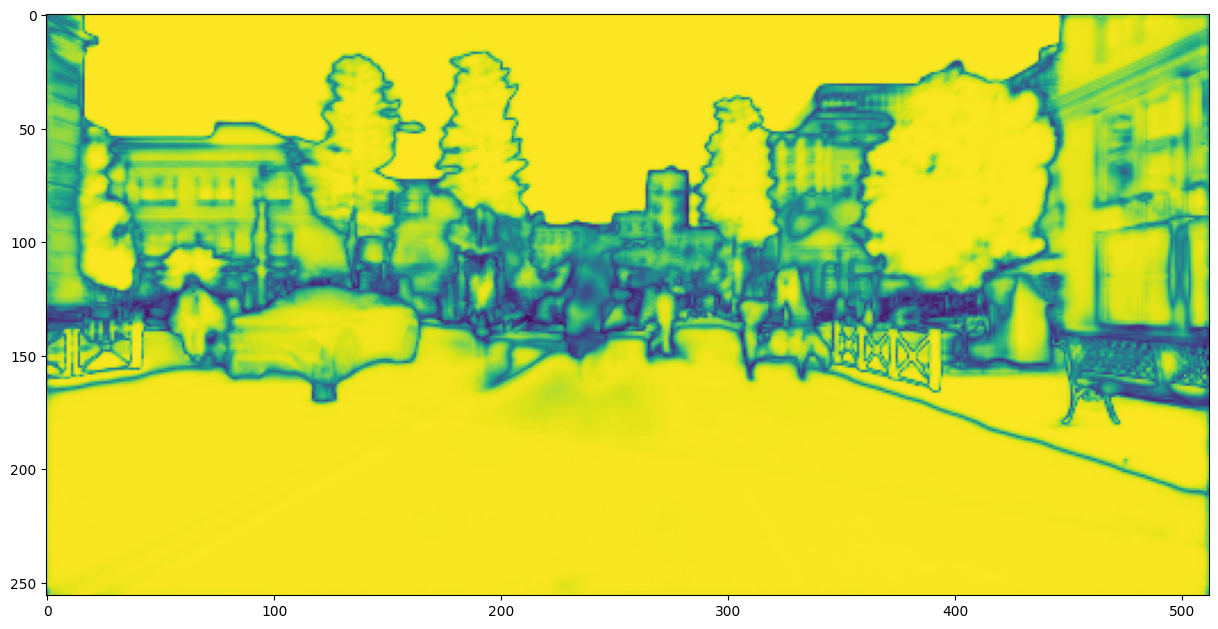

In [85]:
confidence_img = F.to_pil_image(confidence)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(confidence_img)
plt.show()

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**  



In our case the model didn't get more confident nor better calibrated since the plots are worse (higher ECE) and the peak of confidence is even far from the accuracy line.

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

In [86]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout

**Try the MC dropout code with a low number of estimators like 3 and a high number 20. Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

We can see that the model gets less confident as we increase the number of estimators, since the bright areas in the confidence image are reduced and the dark areas are increased. We can see that the road, the bear and goat areas are darker, for example.

In [87]:
mc_model_1 = mc_dropout(model, num_estimators=1)
mc_model_2 = mc_dropout(model, num_estimators=100)

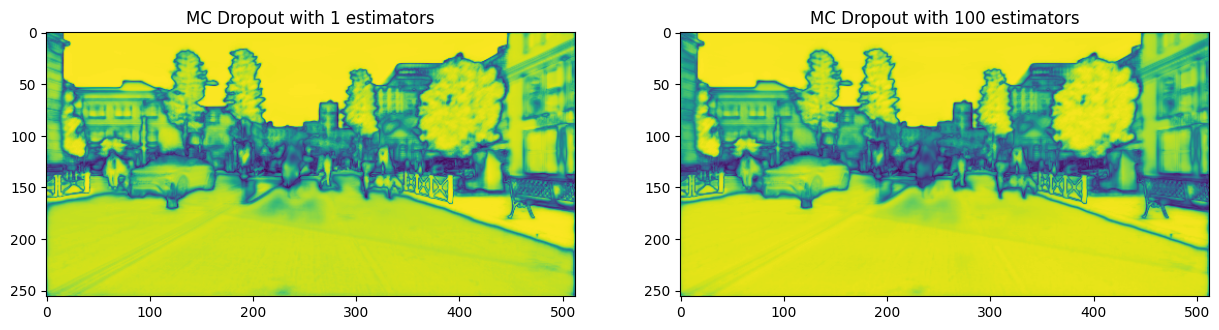

In [88]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)

mc_model_1.eval()
mc_model_2.eval()

with torch.no_grad():
    outputs_1 = mc_model_1(batch_img)
    outputs_proba_1 = outputs_1.softmax(dim=1)
    mean_proba_1 = outputs_proba_1.mean(dim=0)
    confidence1, pred1 = mean_proba_1.max(dim=0)

    outputs_2 = mc_model_2(batch_img)
    outputs_proba_2 = outputs_2.softmax(dim=1)
    mean_proba_2 = outputs_proba_2.mean(dim=0)
    confidence2, pred2 = mean_proba_2.max(dim=0)

confidence_img1 = F.to_pil_image(confidence1)
confidence_img2 = F.to_pil_image(confidence2)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].set_title("MC Dropout with 1 estimators")
axs[0].imshow(confidence_img1)
axs[1].set_title("MC Dropout with 100 estimators")
axs[1].imshow(confidence_img2)
plt.show()

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [89]:
from torch_uncertainty.models import deep_ensembles

In [90]:
# load trained models
num_classes = 19
model1 = UNet(num_classes).to(device)
model1 = torch.nn.DataParallel(model1)
model1.load_state_dict(torch.load("model1.pth"))

model2 = UNet(num_classes).to(device)
model2 = torch.nn.DataParallel(model2)
model2.load_state_dict(torch.load("model2.pth"))

# to be trained yet
# model3 = UNet(19).to(device)
# model3 = torch.nn.DataParallel(model3)
# model3.load_state_dict(torch.load("model3.pth"))

# ens_model = deep_ensembles([model1, model2, model3])
ens_model = deep_ensembles([model1, model2])

/tmp/ipykernel_1181792/2380647022.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load("model1.pth"))
/tmp/ipykernel_1181792/2380647022.py:9

Test your ensemble obtained either using option 1 or 2.

In [91]:
def test_ensemble(ens_model, data_loader, criterion, metric, iteration_loss=False):
    ens_model.eval()
    epoch_loss = 0.0
    metric.reset()
    n_models = len(ens_model.core_models)

    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].to(device)
        labels = batch_data[1].squeeze(1).to(device)

        with torch.no_grad():
            # Forward propagation
            logits = ens_model(img)
            ensemble_logits = rearrange(logits, "(n b) c h w -> n b c h w", n=n_models)
            ensemble_probs = ensemble_logits.softmax(dim=2)
            avg_probs = ensemble_probs.mean(dim=0)  # [B, C, H, W]

            # Flatten logits and labels
            flatten_probs = rearrange(avg_probs, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255

            # Loss computation (designed for NLL loss)
            loss = criterion(flatten_probs[valid_mask], flatten_labels[valid_mask])

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_probs[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute().item()

In [92]:
# the loss should be positive here, we have to fix
torch.cuda.empty_cache()
ens_criterion = nn.NLLLoss(weight=class_weights)
ens_metric = MeanIntersectionOverUnion(num_classes=num_classes).to(device)

loss, iou, miou = test_ensemble(
    ens_model, test_loader, ens_criterion, ens_metric, iteration_loss=True
)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss, " | Mean IoU: ", miou)

for key, class_iou in zip(test_set.classes[:19], iou, strict=True):
    print(f"{key}: {class_iou:.4f}")

/home/ids/glorenzo-23/tp_uncertainty/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Step: 0] Iteration loss: -0.7085
[Step: 1] Iteration loss: -0.6820
[Step: 2] Iteration loss: -0.7064
[Step: 3] Iteration loss: -0.7143
>>>> [FINAL TEST on the test set: ] Avg. loss:  -0.7028162479400635  | Mean IoU:  0.4467340111732483
MUADClass(name='road', id=0, color=(128, 64, 128)): 0.9388
MUADClass(name='sidewalk', id=1, color=(244, 35, 232)): 0.6882
MUADClass(name='building', id=2, color=(70, 70, 70)): 0.8087
MUADClass(name='wall', id=3, color=(102, 102, 156)): 0.0000
MUADClass(name='fence', id=4, color=(190, 153, 153)): 0.4356
MUADClass(name='pole', id=5, color=(153, 153, 153)): 0.2445
MUADClass(name='traffic_light', id=6, color=(250, 170, 30)): 0.0641
MUADClass(name='traffic_sign', id=7, color=(220, 220, 0)): 0.0000
MUADClass(name='vegetation', id=8, color=(107, 142, 35)): 0.5842
MUADClass(name='terrain', id=9, color=(152, 251, 152)): 0.0000
MUADClass(name='sky', id=10, color=(70, 130, 180)): 0.9239
MUADClass(name='person', id=11, color=(220, 20, 60)): 0.4077
MUADClass(name='r

Save the ensemble model

In [93]:
final_model_path = "ensemble.pth"
torch.save(ens_model.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to ensemble.pth


In [94]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).to(device)
batch_target = target.unsqueeze(0).to(device)

model1.eval()
ens_model.eval()

with torch.no_grad():
    outputs_1 = model1(batch_img)
    outputs_proba_1 = outputs_1.softmax(dim=1)
    mean_proba_1 = outputs_proba_1.mean(dim=0)
    confidence1, pred1 = mean_proba_1.max(dim=0)

    outputs_2 = ens_model(batch_img)
    outputs_proba_2 = outputs_2.softmax(dim=1)
    mean_proba_2 = outputs_proba_2.mean(dim=0)
    confidence2, pred2 = mean_proba_2.max(dim=0)

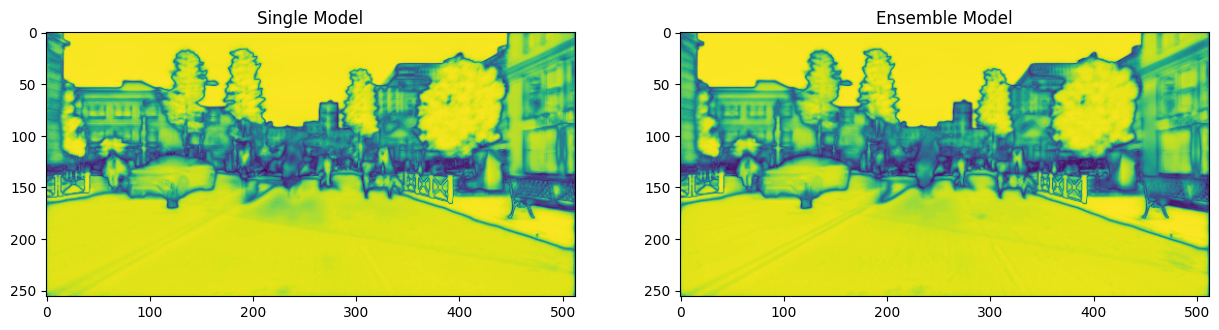

In [95]:
confidence_img1 = F.to_pil_image(confidence1)
confidence_img2 = F.to_pil_image(confidence2)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].set_title("Single Model")
axs[0].imshow(confidence_img1)
axs[1].set_title("Ensemble Model")
axs[1].imshow(confidence_img2)
plt.show()

## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**


In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_uncertainty.layers import PackedConv2d
from einops import rearrange


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch, alpha, num_estimators, first=False, last=False):
        super().__init__()
        self.conv = nn.Sequential(
            PackedConv2d(
                in_ch,
                out_ch,
                3,
                padding=1,
                alpha=alpha,
                num_estimators=num_estimators,
                first=first,
            ),
            nn.BatchNorm2d(alpha * out_ch),
            nn.ReLU(inplace=True),
            PackedConv2d(
                out_ch,
                out_ch,
                3,
                padding=1,
                alpha=alpha,
                num_estimators=num_estimators,
                last=last,
            ),
            nn.BatchNorm2d(alpha * out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch, alpha, num_estimators):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch, alpha, num_estimators, first=True)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch, alpha, num_estimators):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_ch, out_ch, alpha, num_estimators)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, alpha, num_estimators, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        self.num_estimators = num_estimators
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch, alpha, num_estimators)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.interpolate(
                x1,
                size=[2 * x1.size()[2], 2 * x1.size()[3]],
                mode="bilinear",
                align_corners=True,
            )
        else:
            x1 = self.up(x1)

        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2]
        )

        m = self.num_estimators
        x1 = rearrange(x1, "(m B) C H W -> B m C H W", m=m)
        x2 = rearrange(x2, "(m B) C H W -> B m C H W", m=m)

        x = torch.cat([x2, x1], dim=2)  # Now (B, m, 2C, H, W)
        x = rearrange(x, "B m C H W -> (m B) C H W")

        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch, alpha, num_estimators):
        super().__init__()
        self.conv = PackedConv2d(
            in_ch, out_ch, 1, alpha=alpha, num_estimators=num_estimators, last=True
        )

    def forward(self, x):
        return self.conv(x)


class PackedUNet(nn.Module):
    def __init__(self, classes, alpha=2, num_estimators=4):
        super().__init__()
        self.num_estimators = num_estimators
        self.inc = InConv(3, 32, alpha, num_estimators)
        self.down1 = Down(32, 64, alpha, num_estimators)
        self.down2 = Down(64, 128, alpha, num_estimators)
        self.down3 = Down(128, 256, alpha, num_estimators)
        self.down4 = Down(256, 256, alpha, num_estimators)
        self.up1 = Up(512, 128, alpha, num_estimators)
        self.up2 = Up(256, 64, alpha, num_estimators)
        self.up3 = Up(128, 32, alpha, num_estimators)
        self.up4 = Up(64, 32, alpha, num_estimators)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes, alpha, num_estimators)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

In [ ]:
from torch_uncertainty.transforms import RepeatTarget
from torch_uncertainty.routines import ClassificationRoutine
from torch_uncertainty import TUTrainer


def optim_recipe(model, lr_mult: float = 1.0):
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate * lr_mult, weight_decay=weight_decay
    )
    scheduler = lr_scheduler.StepLR(
        optimizer, step_size=lr_decay_epochs, gamma=lr_decay
    )
    return {"optimizer": optimizer, "scheduler": scheduler}


model = PackedUNet(classes=19, alpha=2, num_estimators=4).to(device)

trainer = TUTrainer(accelerator="cuda", max_epochs=50)

routine = ClassificationRoutine(
    is_ensemble=True,
    num_classes=19,
    model=model,
    loss=nn.CrossEntropyLoss(),
    format_batch_fn=RepeatTarget(4),
    optim_recipe=optim_recipe(model, 4.0),
    eval_ood=True,
)

trainer.fit(routine, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
perf = trainer.test(routine, dataloaders=[test_loader, test_ood_set])

**Please conclude your report**